# Playing with P-values

## Recall some definitions 

* $H_0$ : null hypothesis: The hypotheis that the effect we are testing for is null

* $H_A$ : alternative hypothesis : Not $H_0$, so there is some signal

* $T$ : The random variable that takes value "significant" or "not significant"

* $T_S$ : Value of T when test is significant (eg $T = T_S$)

* $T_N$ : Value of T when test is not significant (eg $T = T_N$)

* $\alpha$ : false positive rate - probability to reject $H_0$ when $H_0$ is true (therefore $H_A$ is false)

* $\beta$ : false negative rate - probability to accept $H_0$ when $H_A$ is true (i.e. $H_0$ is false)


## What is P-hacking?

P-hacking is finding regular variations in either data or models and considering them to be significant. The result is a positive report that is not reproducible or does not generalize. It is often unintentional. In this notebook, we'll go through a few examples of how we can find (and subsequently report) statistically-significant results 

## Exercise 1: Random selection

In this exercise, we'll sample data points from a zero-mean Gaussian distribution and test whether the sample mean is significantly different from 0.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as sst

### Step 1: Generate N samples from the normal distribution

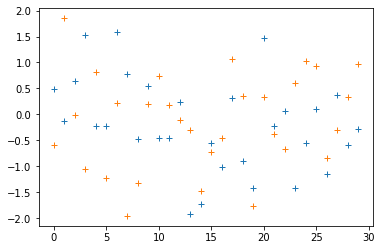

In [2]:
# define the Normal 0,1 object
norm01 = sst.norm(0,1)
# Let's fix the seed of the random generator
np.random.seed(42) # 42 is arbitrary 
# Draw from the normal:
# norm01 has a "random variables" function drawing from this distribution
# and returns a numpy array of a given size
sample = norm01.rvs(size=(30,))
plt.plot(sample,'+')
sample = norm01.rvs(size=(30,))
plt.plot(sample,'+')

#### Is the mean significant? 

In [3]:
# Compute sample mean and corrected standard deviation
sample_mean = sample.mean()
sample_std = sample.std()
N = len(sample)

std_corrected = np.sqrt((sample**2 - sample_mean**2).sum()/(N-1))

# take into account the "N-1" since 1 degrees of freedoms have been used 
# to estimate the mean
# assert not np.isclose(std_corrected, sample_std)
assert np.isclose(std_corrected, np.sqrt(np.var(sample,ddof=1)))

# t-test: compute t statistics
t_value = sample_mean / (std_corrected/np.sqrt(N))


In [4]:
# test it against the null : make a central t distribution 
central_t = sst.t(loc=0,scale=1,df=N-1)

significance_thr = 0.05

# use the survival function
pvalue = central_t.sf(t_value)
print("This is our p-value : {}".format(pvalue))

if pvalue < significance_thr:
    print("Significant p-value!")
else:
    print("Not good enough, continue p-hacking")

This is our p-value : 0.7591488146556591
Not good enough, continue p-hacking


#### Estimate the chance that our p-value is significant under the null:

In [5]:
print(norm01.rvs(size=(2,)))

[-0.47917424 -0.18565898]


In [6]:
# create a function that generate a p-value when data are from N(0,1)

def yield_a_pvalue(distrib, N=30):
    """
    Parameters
    ----------
    distrib:  distribution object(eg, norm(0,1))
        a scipy.stats distribution 
    
    Returns
    -------
    A p-value
    """
    sample = distrib.rvs(size=(N,))
    sample_mean = sample.mean()
    std_corrected = np.sqrt(np.var(sample, ddof=1))

    # compute t statistics
    t_value = sample_mean / (std_corrected/np.sqrt(N))
    
    return sst.t.sf(t_value, df=N-1)


In [7]:
# On average: 20 
nb_of_test_needed = 0
while yield_a_pvalue(norm01) > significance_thr:
    nb_of_test_needed += 1
print(nb_of_test_needed)

8


In [8]:
N_pval = 100
pvalues = np.asarray([yield_a_pvalue(sst.norm(0,1)) for i in range(N_pval)])
number_significant = (pvalues <= significance_thr).sum()
print("We have {} tests significant over {} trials, ie {}%"
              .format(number_significant, N_pval, 100*number_significant/N_pval))


We have 8 tests significant over 100 trials, ie 8.0%


### Sample from non-zero mean:

In [9]:
def launch_a_bunch_of_tests(distrib, N_pval=1000, N=30):
    """
    launches a series of sampling and then t tests on these (testing if the mean is > 0)
    
    Parameters:
    -----------
    distrib: the sampling distribution
    N_pval: number of p-value to compute
    N : the sample size
    """
    pvalues = np.asarray([yield_a_pvalue(distrib) for i in range(N_pval)])
    number_significant = (pvalues <= significance_thr).sum()
    print("We have {} tests significant over {} trials, ie {}%"
                  .format(number_significant, N_pval, 100*number_significant/N_pval))


# Demonstrate that the test depends only on the signal to noise ratio, not the effect size
    
# case 1: m=1.65, sigma=1
#---------------------------
loc, scale = (1.65/np.sqrt(N), 1)
distrib = sst.norm(loc, scale)
launch_a_bunch_of_tests(distrib)
# case 1: m=0.165, sigma=0.1
#---------------------------
loc, scale = (0.165/np.sqrt(N), 0.1)
distrib = sst.norm(loc, scale)
launch_a_bunch_of_tests(distrib)



We have 486 tests significant over 1000 trials, ie 48.6%
We have 491 tests significant over 1000 trials, ie 49.1%


# Exercise 2: Overfitting

Overfitting refers to a model (e.g. a GLM) that fits too closely to the data on which it is trained and its predictions can't reproduced on new data.
Overfitting can occur when there is very little data or if your model has too many parameters. For example, a GLM with 1000 explanatory variables can be might fit well to the time series of 4 subjects, but is unlikely to do well on a different set of 4 subjects.

In this exercise, we'll create some data and use regression to fit a model. The important parts of the code are the "modify" section for you to modify and examine the resulting changes.
The number of samples, "n_samples" is the amount of data you have.
The number of model parameters, "degrees" is the number of degrees of freedom given to your model. It will perform a linear regression on our generated data and a polynomial of the given degrees.

Taken from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py

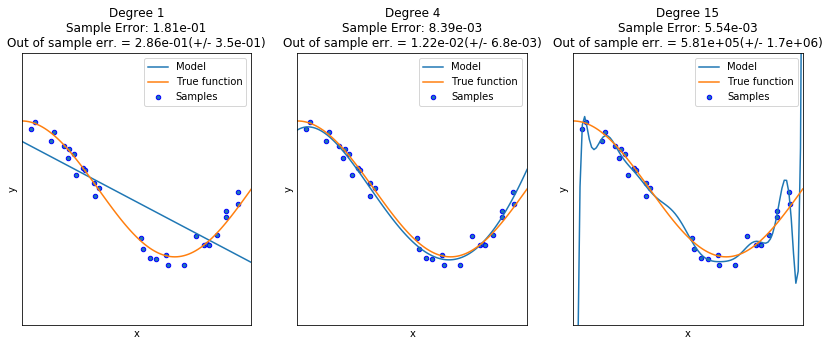

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# Define a function for us to fit; here we'll take a simple cosine
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

###
# Modify
###
n_samples = 30  # Number of data points
degrees = [1, 4, 15]   # Number of parameters; change the values to see the effect on out of sample error
                       # For degree 4, the model will fit Y = b0 + b1*x + b2*x^2 + b3*x^3 + b4*x^4
###

test_max_value=1
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
X_test = np.linspace(0, test_max_value, 100)
plt.figure(figsize=(14, 5))

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    train_score = mean_squared_error(y, pipeline.predict(X[:, np.newaxis]))
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, np.max(X_test)))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nSample Error: {:.2e}\nOut of sample err. = {:.2e}(+/- {:.1e})".format(
        degrees[i], train_score.mean(), -scores.mean(), scores.std()))
plt.show()

Examine the three previous plots.
The "Sample error" is the error for the data in your sample; it represents the error you would have if you evaluated your model on data it had already seen.
The "Out of sample error" is the error when your model is evaluated on data it has not seen. It represents how well your model generalizes.
In both cases, a lower error is better.

1) The left-most plot presents a plausible model.

2) The polynomial of degree 4 has the lowest out of sample error, indicating that it is the best-performing model.

3) The high-degree polynomial has the lowest sample error, but a very large out of sample error, indicating that it does not generalize well.

If we were to select our high-degree polynomial and report those results, we can immediately see that our results could not be reproduced.

### Exercise 3: Real Data

The previous exercises examined toy examples. 


In [11]:
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

data = pd.read_csv('brain_size.csv', delimiter=';', header=0, index_col=0)
linear_regression = LinearRegression()

In [12]:
# Let's first look at our data:
data.describe()

,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,38.000000,38.000000,38.000000,38.000000,38.000000,3.800000e+01
mean,113.552632,112.131579,111.342105,151.052632,68.421053,9.067542e+05
std,23.815391,22.939605,22.597867,23.478509,3.993790,7.256175e+04
min,77.000000,71.000000,72.000000,106.000000,62.000000,7.906190e+05
25%,90.250000,90.250000,89.250000,135.250000,66.000000,8.548115e+05
50%,116.500000,113.000000,115.000000,146.500000,68.000000,9.053990e+05
75%,135.000000,129.000000,128.000000,172.000000,70.375000,9.495405e+05
max,144.000000,150.000000,150.000000,192.000000,77.000000,1.079549e+06


The dataset is relatively simple, and contains 38 subjects with Full Scale, Verbal, and Perceptual IQ, as well as weight, height, and brain volume ("MRI_Count"). We'll repeat the previous exercise and we'll see a similar pattern.

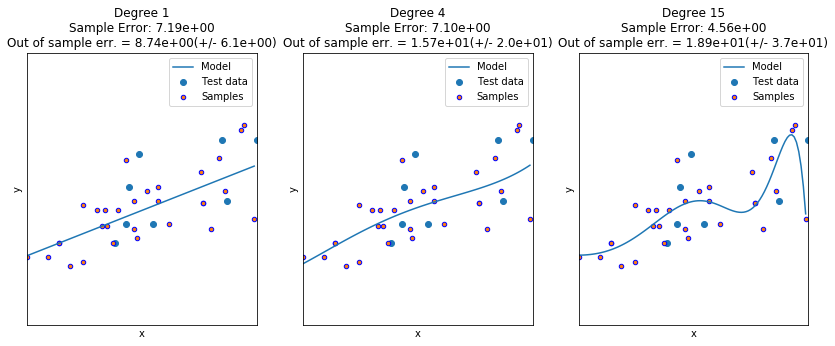

In [13]:
###
# Modify
###
num_subject = 30       # Number of subjects for in-sample data (must be less than 38)
degrees = [1, 4, 15]   # For degree 4, the model will fit Y = b0 + b1*x + b2*x^2 + b3*x^3 + b4*x^4
input_variable='Weight'
predicted_variable='Height'
###

test_max_value=1

X = np.array(data[input_variable][:num_subject]).T[:, np.newaxis]
y = np.array(data[predicted_variable][:num_subject]).T[:, np.newaxis]

X_test = np.array(data[input_variable][num_subject:]).T
xind = np.argsort(X_test)
X_test = np.take_along_axis(X_test, xind, 0)[:, np.newaxis]
y_test = np.array(data[predicted_variable][num_subject:]).T
y_test = np.take_along_axis(y_test, xind, 0)[:, np.newaxis]
plt.figure(figsize=(14, 5))

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X, y)

    # Evaluate the models using crossvalidation
    train_score = mean_squared_error(y, pipeline.predict(X))
    scores = cross_val_score(pipeline, X, y,
                             scoring="neg_mean_squared_error", cv=10)

    m_range = np.linspace(np.min(X), np.max(X), 100)[:, np.newaxis]
    
    plt.plot(m_range, pipeline.predict(m_range), label="Model")
    plt.scatter(X_test, y_test, label="Test data")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((np.min(X), np.max(X_test)))
    plt.ylim((np.min(y)*0.9, np.max(y)*1.1))
    plt.legend(loc="best")
    plt.title("Degree {}\nSample Error: {:.2e}\nOut of sample err. = {:.2e}(+/- {:.1e})".format(
        degrees[i], train_score.mean(), -scores.mean(), scores.std()))
plt.show()